In [1]:
# ===== T-GCN with TRAIN-ONLY MLP Imputation + Continuous-Block Sampling =====
# - Fits an MLP imputer per feature using only TRAIN rows (per BA), then imputes TRAIN & VAL.
# - (Optional) can impute TEST with the same train-fitted imputers (set IMPUTE_TEST=True if needed).
# - Builds sliding windows only within continuous 1-hour blocks (no-crossing gaps).
# - Uses monthly dynamic graphs and a batched GCN (block-diagonal trick).

import os, glob, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv   # swap to ChebConv for wider K
from sklearn.metrics import r2_score
from pandas.tseries.holiday import USFederalHolidayCalendar
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# ------------------- Config -------------------
SEED = 391
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

INPUT_LEN  = 168
HORIZON    = 1
STRIDE     = 1
RNN_TYPE   = "lstm"      # "gru" or "lstm"
GCN_H      = 32
RNN_H      = 128
NUM_LAYERS = 1
BIDIR      = False
BATCH      = 32
EPOCHS     = 150
PATIENCE   = 25
LR         = 1e-3

IMPUTE_TARGET = False     # generally False to avoid training on imputed labels
IMPUTE_TEST   = False     # set True if your test still has NaNs you need to fill

FEATURES = ['Hour_sin','Hour_cos','Month_sin','Month_cos','T2','Q2','WSPD','GLW','SWDOWN','Weekday','Holiday']
TARGET   = 'Adjusted_Demand_MWh'

def get_interpolated_feats(years, months, ba_index, device):
    years_np  = years.cpu().numpy()
    months_np = months.cpu().numpy()

    # 插值权重 w: [B]
    w = (months_np - 1) / 12.0

    # 当前年特征 [B,4]
    f_cur = np.stack([ba_static_feats_by_year[int(y)][ba_index].cpu().numpy()
                      for y in years_np])

    # 下一年特征 [B,4]（2019 特殊处理）
    f_next = np.stack([
        ba_static_feats_by_year[int(y)+1][ba_index].cpu().numpy() if y < 2019
        else ba_static_feats_by_year[int(y)][ba_index].cpu().numpy()
        for y in years_np
    ])

    # 线性插值
    f_interp = (1 - w[:, None]) * f_cur + w[:, None] * f_next
    return torch.tensor(f_interp, dtype=torch.float32, device=device)  # [B,4]


# ------------------- MLP Imputation -------------------
class MLPImputer(nn.Module):
    def __init__(self, input_size, hidden_size=447):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

def fit_mlp_on_train(train_df, col_to_fit, input_cols, device='cpu', max_epochs=100):
    # Use only complete rows in TRAIN
    mask = train_df[input_cols + [col_to_fit]].notna().all(axis=1)
    if mask.sum() < 50:   # guardrail
        return None
    X = torch.tensor(train_df.loc[mask, input_cols].values, dtype=torch.float32).to(device)
    y = torch.tensor(train_df.loc[mask, col_to_fit].values, dtype=torch.float32).unsqueeze(1).to(device)

    model = MLPImputer(X.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = nn.MSELoss()
    model.train()
    for _ in range(max_epochs):
        opt.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
    return model

def apply_imputer(df, model, col_to_fill, input_cols, device='cpu'):
    if model is None:
        return
    miss_mask = df[col_to_fill].isna() & df[input_cols].notna().all(axis=1)
    if miss_mask.sum() == 0:
        return
    X = torch.tensor(df.loc[miss_mask, input_cols].values, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_imp = model(X).cpu().squeeze().numpy()
    df.loc[miss_mask, col_to_fill] = y_imp

def train_imputers_from_train(train_df, feature_cols, target_col, device='cpu'):
    imputers = {}
    # For imputing FEATURES: use other FEATURES only (no target to avoid leakage)
    for c in feature_cols:
        other = [v for v in feature_cols if v != c]
        imputers[c] = fit_mlp_on_train(train_df, c, other, device=device)
    # (Optional) target imputer using FEATURES only
    if IMPUTE_TARGET:
        imputers[target_col] = fit_mlp_on_train(train_df, target_col, feature_cols, device=device)
    else:
        imputers[target_col] = None
    return imputers

def impute_with_trained_imputers(df, imputers, feature_cols, target_col, device='cpu'):
    for c in feature_cols:
        apply_imputer(df, imputers[c], c, [v for v in feature_cols if v != c], device=device)
    # Target (if enabled)
    if imputers[target_col] is not None:
        apply_imputer(df, imputers[target_col], target_col, feature_cols, device=device)
    return df

# ------------------- Continuous blocks -------------------
def find_continuous_blocks(dt_series, min_len=1):
    """Return list of (start_idx, end_idx_inclusive) for contiguous 1-hour steps."""
    dt = pd.to_datetime(pd.Series(dt_series)).reset_index(drop=True)
    if dt.empty: return []
    gap = dt.diff().fillna(pd.Timedelta(hours=1)) != pd.Timedelta(hours=1)
    block_ids = gap.cumsum().values
    blocks = []
    for bid in np.unique(block_ids):
        idx = np.where(block_ids == bid)[0]
        if len(idx) >= min_len:
            blocks.append((idx[0], idx[-1]))
    return blocks

# ------------------- Corr->Graph for monthly graphs -------------------
def build_knn_graph_from_corr(corr, k=5, positive_only=True):
    corr = np.array(corr, dtype=np.float64)
    corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
    rank_mat = corr.copy()
    np.fill_diagonal(rank_mat, -np.inf)
    if positive_only:
        rank_mat = np.where(rank_mat > 0.0, rank_mat, -np.inf)
    N = corr.shape[0]; k = max(0, min(int(k), N-1))
    A = np.zeros_like(corr)
    for i in range(N):
        top_idx = np.argsort(-rank_mat[i])[:k]
        A[i, top_idx] = 1.0
    A = ((A > 0) | (A.T > 0)).astype(float)
    ii, jj = np.nonzero(A)
    edge_index = torch.tensor(np.stack([ii, jj], axis=0), dtype=torch.long)
    edge_weight = torch.ones(ii.shape[0], dtype=torch.float32)
    return A, edge_index, edge_weight

# ------------------- Batched GCN helper -------------------
def make_block_edge_index(ei, ew, num_nodes, Bgrp, device):
    E = ei.size(1)
    ei_big = ei.repeat(1, Bgrp)
    offsets = (torch.arange(Bgrp, device=device) * num_nodes).repeat_interleave(E)
    ei_big = ei_big + offsets.unsqueeze(0)
    ew_big = ew.repeat(Bgrp) if ew is not None else None
    return ei_big, ew_big

_graph_cache = {}

# 只缓存基础月图
_month_graph_cache = {}

def get_block_graph(month, Bgrp, N, device):
    """
    month: 月份 (1~12)
    Bgrp : 该月 batch 内样本数
    N    : 节点数
    """
    # 只缓存基础图
    if month not in _month_graph_cache:
        ei, ew = graph_for_month(month)   # 从你算好的 month_graphs 取
        _month_graph_cache[month] = (ei, ew)

    ei, ew = _month_graph_cache[month]
    ei = ei.to(device)
    ew = (ew.to(device) if ew is not None else None)

    # 按当前 batch 扩展一次
    ei_big, ew_big = make_block_edge_index(ei, ew, N, Bgrp, device)
    return ei_big, ew_big


# ------------------- T-GCN (GCN -> RNN) -------------------
class TGCN_BA_RNN(nn.Module):
    def __init__(self, in_ch, gcn_hidden, rnn_hidden, ba_index,
                 graph_for_month_fn, pi_array, rnn_type="gru", num_layers=1, bidirectional=False, dropout=0.3, pi_dim=32):
        super().__init__()
        self.gcn = GCNConv(in_ch, gcn_hidden)
        self.zpi = ZPIEncoder(out_dim=pi_dim)
        self.register_buffer("pi_array", torch.tensor(pi_array, dtype=torch.float32).unsqueeze(0))  # 保存固定的 ZPI
        self.attn = nn.MultiheadAttention(
            embed_dim=gcn_hidden + pi_dim,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.a = nn.Parameter(torch.tensor(0.0))
        rnn_cls = nn.GRU if rnn_type.lower()=="gru" else nn.LSTM
        self.rnn = rnn_cls(gcn_hidden+pi_dim, rnn_hidden, num_layers=num_layers,
                           batch_first=True, bidirectional=bidirectional)

        # ---- 新增: 静态特征 MLP ----
        self.static_mlp = nn.Sequential(
            nn.Linear(4, 16),    # 原始 4 个 customer 特征
            nn.ReLU(),
            nn.Linear(16, 16)    # 输出 16 维 embedding
        )

        # ---- 主预测头 ----
        self.mlp_head = nn.Sequential(
            nn.Linear(rnn_hidden * (2 if bidirectional else 1) + 16, 64),  
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # residual gate (原始 GCN 残差部分)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.proj = nn.Linear(in_ch, gcn_hidden)
        self.dropout = nn.Dropout(dropout)

        self.ba_index = int(ba_index)
        self.graph_for_month = graph_for_month_fn
        self.gcn_hidden = gcn_hidden
        self.rnn_type = rnn_type.lower()

    def forward(self, x_seq, months_seq, ba_static_batch):
        B, L, N, F = x_seq.shape
        dev = x_seq.device

        # flatten 输入 + GCN
        x_flat = x_seq.reshape(B*L, N, F).reshape(-1, F)
        months_flat = months_seq.reshape(-1)
        ba_emb_out = torch.empty(B*L, self.gcn_hidden, device=dev)

        for m in months_flat.unique().tolist():
            idx = (months_flat == m).nonzero(as_tuple=False).squeeze(1)
            xb = x_seq.reshape(B*L, N, F)[idx]
            xg = xb.reshape(-1, F)
            ei_big, ew_big = get_block_graph(int(m), idx.numel(), N, dev)
            h_flat = self.gcn(xg, ei_big, edge_weight=ew_big)
            h_grp = h_flat.view(idx.numel(), N, self.gcn_hidden)

            raw_proj = self.proj(xb[:, self.ba_index, :])
            h_ba = h_grp[:, self.ba_index, :]
            gate = torch.sigmoid(self.alpha)
            h_res = gate * h_ba + (1 - gate) * raw_proj
            h_res = self.dropout(h_res)
            ba_emb_out[idx] = h_res

        ba_emb = ba_emb_out.view(B, L, self.gcn_hidden)

        pi_emb = self.zpi(self.pi_array.to(x_seq.device))
        pi_emb = pi_emb.repeat(B, 1)
        pi_emb_exp = pi_emb.unsqueeze(1).expand(-1, L, -1)

        ba_emb_aug = torch.cat([ba_emb, pi_emb_exp], dim=-1)

        attn_out, _ = self.attn(ba_emb_aug, ba_emb_aug, ba_emb_aug)
        ba_emb_aug = (1 - self.a) * ba_emb_aug + self.a * attn_out

        # ---- RNN 输出 [B, L, RNN_H] ----
        rnn_out, _ = self.rnn(ba_emb_aug)

        # ---- 静态特征 embedding ----
        static_emb = self.static_mlp(ba_static_batch)
        static_emb_exp = static_emb.unsqueeze(1).expand(-1, rnn_out.size(1), -1)

        # ---- 拼接每个时刻 + 预测整段 ----
        h_cat = torch.cat([rnn_out, static_emb_exp], dim=-1)
        out_seq = self.mlp_head(h_cat).squeeze(-1)  # [B, L]

        return out_seq



# ------------------- Sequence dataset honoring blocks -------------------
class SeqGraphDataset(Dataset):
    def __init__(self, x_tensor, y_tensor, months_arr, years_arr, blocks,
                 ba_index, input_len=168, stride=1):
        assert x_tensor.shape[0] == y_tensor.shape[0] == len(months_arr) == len(years_arr)
        self.x = x_tensor
        self.y_ba = y_tensor[:, ba_index]
        self.months = torch.tensor(months_arr, dtype=torch.long)
        self.years  = torch.tensor(years_arr, dtype=torch.long)
        self.L, self.stride = input_len, stride
        self.starts = []
        for (s, e) in blocks:
            max_start = e - s + 1 - self.L
            if max_start >= 0:
                self.starts.extend(list(range(s, s + max_start + 1, self.stride)))

    def __len__(self): 
        return len(self.starts)
    
    def __getitem__(self, i):
        s = self.starts[i]
        e = s + self.L
        x_seq = self.x[s:e]          # [L, N, F]
        y_seq = self.y_ba[s:e]       # ✅ 输出同长度的负荷 [L]
        m_seq = self.months[s:e]
        year_seq = self.years[s:e]
        return x_seq, y_seq, m_seq, year_seq



# ------------------- Load & prepare data (with imputation) -------------------
# Load adjacency names, files
adj_df = pd.read_csv('WECC_adjacent.csv', index_col=0)
ba_names = list(adj_df.index)
ba_files = {fp.split('/')[-1].replace('_cleaned_historical_data.csv', ''): fp
            for fp in glob.glob('./cleaned_data_16-24/*.csv')}

# ------------------- Load static BA features by year -------------------
files = {
    2016: "BA_2016summaries.xlsx",
    2017: "BA_2017summaries.xlsx",
    2018: "BA_2018summaries.xlsx",
    2019: "BA_2019summaries.xlsx",
    2020: "BA_2020summaries.xlsx",
    2021: "BA_2021summaries.xlsx",
    2022: "BA_2022summaries.xlsx",
    2023: "BA_2023summaries.xlsx",
    2024: "BA_2024summaries.xlsx",
}

ba_static_feats_by_year = {}
train_feats = []

# print("ba_names:", ba_names)
# print("Number of ba_names:", len(ba_names))
# print("Has NaN in ba_names?", any(pd.isna(ba_names)))
# print("Excel BA_CODEs (2016):", pd.read_excel(files[2016])["BA_CODE"].tolist())

# 先收集 2016 和 2017 的静态特征用于 min/max
for year in [2016, 2017, 2018, 2019, 2020]:
    df = pd.read_excel(files[year]).set_index("BA_CODE").loc[ba_names]
    feats = df[[
        "Residential_Customers",
        "Commercial_Customers",
        "Industrial_Customers",
        "Transportation_MWh"
    ]].values.astype(np.float32)
    train_feats.append(feats)

# 计算 train (16–17) 的全局 min/max
train_feats = np.vstack(train_feats)  # shape [(2*N), 4]
min_feat = train_feats.min(axis=0)
max_feat = train_feats.max(axis=0)
denom_feat = np.where(max_feat - min_feat == 0, 1.0, max_feat - min_feat)

# 对所有年份做归一化（用 train 的 min/max）
for year, path in files.items():
    df = pd.read_excel(path).set_index("BA_CODE").loc[ba_names]
    feats = df[[
        "Residential_Customers",
        "Commercial_Customers",
        "Industrial_Customers",
        "Transportation_MWh"
    ]].values.astype(np.float32)
    feats_norm = (feats - min_feat) / denom_feat
    ba_static_feats_by_year[year] = torch.tensor(feats_norm, dtype=torch.float32)  # [N,4]

print("Static features normalized with train years (2016–2017).")

# ------------------- Pass 1: Impute per BA, collect available dates -------------------
per_ba_data = {}
per_ba_dates = []

for ba in ba_names:
    df = pd.read_csv(ba_files[ba])
    df['Hour_sin']  = np.sin(2 * np.pi * df['Hour']  / 24.0)
    df['Hour_cos']  = np.cos(2 * np.pi * df['Hour']  / 24.0)
    df['Month_sin'] = np.sin(2 * np.pi * (df['Month']-1) / 12.0)  # Month 1~12 -> 0~11
    df['Month_cos'] = np.cos(2 * np.pi * (df['Month']-1) / 12.0)
    df['Date']  = pd.to_datetime(df[['Year','Month','Day','Hour']])
    df['Date1'] = pd.to_datetime(df[['Year','Month','Day']])
    # Weekday & Holiday
    df['Weekday'] = (df['Date1'].dt.weekday < 5).astype(int)
    cal = USFederalHolidayCalendar()
    df['Holiday'] = df['Date1'].isin(cal.holidays(start=df['Date1'].min(),
                                                 end=df['Date1'].max())).astype(int)

    # Split
    tr = df[df['Year'].isin([2016, 2017, 2018, 2019, 2020, 2021, 2022])].copy()
    va = df[df['Year'].isin([2023])].copy()
    te = df[df['Year'].isin([2024])].copy()

    # ---- MLP IMPUTATION ----
    cyclical_cols = ['Hour_sin','Hour_cos','Month_sin','Month_cos']
    mlp_features  = [f for f in FEATURES if f not in cyclical_cols]
    imputers = train_imputers_from_train(tr, mlp_features, TARGET, device=device)
    tr = impute_with_trained_imputers(tr, imputers, mlp_features, TARGET, device=device)
    va = impute_with_trained_imputers(va, imputers, mlp_features, TARGET, device=device)
    if IMPUTE_TEST:
        te = impute_with_trained_imputers(te, imputers, mlp_features, TARGET, device=device)

    # Drop rows still missing
    tr.dropna(subset=FEATURES + ([TARGET] if not IMPUTE_TARGET else []), inplace=True)
    va.dropna(subset=FEATURES + ([TARGET] if not IMPUTE_TARGET else []), inplace=True)
    te.dropna(subset=FEATURES + [TARGET], inplace=True)

    # Save imputed splits & available dates
    per_ba_data[ba] = {"train": tr, "val": va, "test": te}
    per_ba_dates.append(set(tr['Date']).union(va['Date']).union(te['Date']))

print("\n=== 检查每个 BA 的测试集最后日期 ===")
for ba in ba_names:
    last_date = per_ba_data[ba]["test"]["Date"].iloc[-1]
    print(f"{ba}: {last_date}")

# Final common dates AFTER imputation
common_dates_final = sorted(list(set.intersection(*per_ba_dates)))
print(f"Final common dates length: {len(common_dates_final)}")

# ------------------- Compute average load per BA (2016–2024) -------------------
avg_loads = {}
for ba in ba_names:
    df_all = pd.concat([
        per_ba_data[ba]["test"]
    ], axis=0)
    avg_loads[ba] = df_all["Adjusted_Demand_MWh"].mean()

avg_load_df = pd.DataFrame.from_dict(avg_loads, orient="index", columns=["Avg_Load"]).reset_index()
avg_load_df.rename(columns={"index": "BA"}, inplace=True)

print("平均负荷 (2016–2024):")
print(avg_load_df.head())
avg_load_df.to_csv("BA_test_avg_loads.csv", index=False)
print("已保存到 BA_test_avg_loads.csv")

Static features normalized with train years (2016–2017).

=== 检查每个 BA 的测试集最后日期 ===
AVA: 2024-12-31 21:00:00
AZPS: 2024-12-31 21:00:00
BANC: 2024-12-31 21:00:00
BPAT: 2024-12-31 21:00:00
CHPD: 2024-12-31 21:00:00
CISO: 2024-12-31 21:00:00
DOPD: 2024-12-31 21:00:00
EPE: 2024-12-31 21:00:00
GCPD: 2024-12-31 21:00:00
IID: 2024-12-31 21:00:00
IPCO: 2024-12-31 21:00:00
LDWP: 2024-12-31 21:00:00
NEVP: 2024-12-31 21:00:00
NWMT: 2024-12-31 21:00:00
PACE: 2024-12-31 21:00:00
PACW: 2024-12-31 21:00:00
PGE: 2024-12-31 21:00:00
PNM: 2024-12-31 21:00:00
PSCO: 2024-12-31 21:00:00
PSEI: 2024-12-31 21:00:00
SCL: 2024-12-31 21:00:00
SRP: 2024-12-31 21:00:00
TEPC: 2024-12-31 21:00:00
TIDC: 2024-12-31 21:00:00
TPWR: 2024-12-31 21:00:00
WACM: 2024-12-31 21:00:00
WALC: 2024-12-31 21:00:00
WAUW: 2024-12-31 21:00:00
Final common dates length: 63807
平均负荷 (2016–2024):
     BA     Avg_Load
0   AVA  1474.049761
1  AZPS  4097.611136
2  BANC  2038.075381
3  BPAT  6723.887042
4  CHPD   224.631747
已保存到 BA_test_avg_lo

Final tensor shapes: torch.Size([46529, 28, 11]) torch.Size([46529, 28])
Built monthly graphs for months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.5 0. ]
[ 1.5 11. ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5
  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5

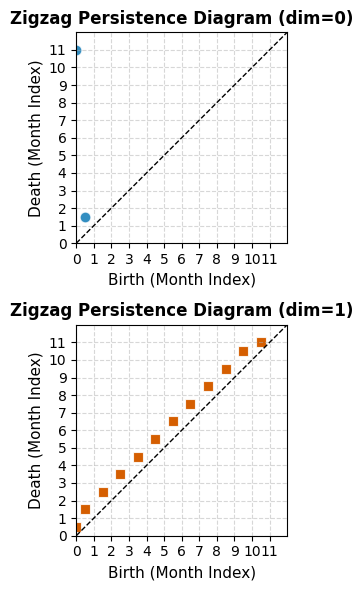

In [5]:
import matplotlib.pyplot as plt
# ------------------- Pass 2: Re-align & normalize -------------------
x_train_list, y_train_list = [], []
x_val_list,   y_val_list   = [], []
x_test_list,  y_test_list  = [], []
min_y_train_list, max_y_train_list = [], []

for ba in ba_names:
    tr = per_ba_data[ba]["train"]
    va = per_ba_data[ba]["val"]
    te = per_ba_data[ba]["test"]

    # Re-align to common dates
    tr = tr[tr['Date'].isin(common_dates_final)].sort_values("Date")
    va = va[va['Date'].isin(common_dates_final)].sort_values("Date")
    te = te[te['Date'].isin(common_dates_final)].sort_values("Date")

    # --- Normalize per BA using TRAIN only ---
    Xtr = tr[FEATURES].values;  ytr = tr[TARGET].values.reshape(-1,1)
    Xva = va[FEATURES].values;  yva = va[TARGET].values.reshape(-1,1)
    Xte = te[FEATURES].values;  yte = te[TARGET].values.reshape(-1,1)

    min_x = np.min(Xtr, axis=0); max_x = np.max(Xtr, axis=0)
    min_y = np.min(ytr, axis=0); max_y = np.max(ytr, axis=0)

    denom_x = np.where((max_x - min_x)==0, 1.0, (max_x - min_x))
    denom_y = np.where((max_y - min_y)==0, 1.0, (max_y - min_y))

    x_train_list.append( (Xtr - min_x) / denom_x )
    y_train_list.append( ((ytr - min_y) / denom_y).squeeze() )

    x_val_list.append( (Xva - min_x) / denom_x )
    y_val_list.append( ((yva - min_y) / denom_y).squeeze() )

    x_test_list.append( (Xte - min_x) / denom_x )
    y_test_list.append( ((yte - min_y) / denom_y).squeeze() )

    min_y_train_list.append(float(min_y.item()))
    max_y_train_list.append(float(max_y.item()))

# ------------------- Stack tensors -------------------
x_tensor      = torch.tensor(np.stack(x_train_list, axis=1), dtype=torch.float32)  # [T,N,F]
y_tensor      = torch.tensor(np.stack(y_train_list,   axis=1), dtype=torch.float32) # [T,N]
x_val_tensor  = torch.tensor(np.stack(x_val_list,     axis=1), dtype=torch.float32)
y_val_tensor  = torch.tensor(np.stack(y_val_list,     axis=1), dtype=torch.float32)
x_test_tensor = torch.tensor(np.stack(x_test_list,    axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(np.stack(y_test_list,    axis=1), dtype=torch.float32)

min_y_train_array = np.array(min_y_train_list)
max_y_train_array = np.array(max_y_train_list)

print("Final tensor shapes:", x_tensor.shape, y_tensor.shape)

# Helper to recompute months/dates after common_dates_final
# Helper to recompute months/dates/years after common_dates_final
def months_and_dates_for_splits_after_imputation(ba, common_dates_final):
    df = pd.concat([
        per_ba_data[ba]["train"],
        per_ba_data[ba]["val"],
        per_ba_data[ba]["test"]
    ], axis=0)

    df = df[df['Date'].isin(common_dates_final)].sort_values("Date")
    train = df[df['Year'].isin([2016, 2017, 2018, 2019, 2020, 2021, 2022])]
    val   = df[df['Year'].isin([2023])]
    test  = df[df['Year'].isin([2024])]

    return (
        train['Month'].to_numpy(), val['Month'].to_numpy(), test['Month'].to_numpy(),
        train['Year'].to_numpy(),  val['Year'].to_numpy(),  test['Year'].to_numpy(),
        train['Date'].to_numpy(),  val['Date'].to_numpy(),  test['Date'].to_numpy()
    )



# Recompute using any reference BA
ref_ba = ba_names[0]
months_train_arr, months_val_arr, months_test_arr, \
years_train_arr, years_val_arr, years_test_arr, \
dates_train_arr,  dates_val_arr,  dates_test_arr = \
    months_and_dates_for_splits_after_imputation(ref_ba, common_dates_final)



# 3) Monthly correlations (TRAIN only) to build dynamic graphs
temp_feature_idx = FEATURES.index('T2')
temp_trains = x_tensor[:, :, temp_feature_idx].numpy()  # [T_train, N]

month_corrs = {}
for m in range(1, 13):
    mask = (months_train_arr == m)
    if mask.sum() >= 3:
        corr_m = np.corrcoef(temp_trains[mask, :], rowvar=False)
        month_corrs[m] = corr_m

k = 5
month_graphs = {}
for m, corr in month_corrs.items():
    A, ei, ew = build_knn_graph_from_corr(corr, k=k, positive_only=True)
    month_graphs[m] = {'A': A, 'edge_index': ei, 'edge_weight': ew}

if month_corrs:
    avg_corr = sum(month_corrs.values()) / len(month_corrs)
else:
    avg_corr = np.corrcoef(temp_trains, rowvar=False)

_, ei_avg, ew_avg = build_knn_graph_from_corr(avg_corr, k=k, positive_only=True)

def graph_for_month(m: int):
    g = month_graphs.get(m, None)
    if g is None:
        return ei_avg, ew_avg
    return g['edge_index'], g['edge_weight']


print("Built monthly graphs for months:", sorted(month_graphs.keys()))

A_list = [month_graphs[m]['A'] for m in sorted(month_graphs.keys())]
# dgms = compute_zigzag_from_am(A_list, maxDimHoles=1, scaleParameter=1)

# # 可视化
# for dim, dgm in enumerate(dgms):
#     plt.figure()
#     for pt in dgm:
#         plt.plot([pt.birth, pt.death], [dim, dim], 'b-')
#     plt.title(f"Zigzag barcode (dim={dim})")
#     plt.show()

# def plot_persistence_diagram(dgms):
#     for dim, dgm in enumerate(dgms):
#         births = [pt.birth for pt in dgm]
#         deaths = [
#             pt.death if pt.death < float('inf') else max(births) * 1.2
#             for pt in dgm
#         ]

#         plt.figure(figsize=(4,4))
#         plt.scatter(births, deaths, label=f"dim {dim}", alpha=0.7)
#         min_val, max_val = min(births), max(deaths)
#         plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#         plt.xlabel("Birth")
#         plt.ylabel("Death")
#         plt.title(f"Persistence Diagram (dim={dim})")
#         plt.legend()
#         plt.show()

import numpy as np
import networkx as nx
import dionysus as d
import zigzagtools as zzt
from scipy.spatial.distance import squareform
def convert_dgms_to_numpy(G_dgms):
    """
    G_dgms: list of dionysus Diagram objects
    返回: list of numpy arrays
    """
    dgms_np = []
    for dgm in G_dgms:
        pts = np.array([[p.birth, p.death] for p in dgm])
        dgms_np.append(pts)
    return dgms_np

def month_graphs_to_zigzag(month_graphs, maxDimHoles=1, scaleParameter=1.0, INF=1.1, plot=True):
    """
    month_graphs: dict {month: {'A': adjacency_matrix, ...}}
    例如: month_graphs[1]['A'] = adjacency matrix for January

    返回: G_dgms (Zigzag persistence diagrams)
    """

    # 按月份排序，取 adjacency
    A_list = [month_graphs[m]['A'] for m in sorted(month_graphs.keys())]

    N = A_list[0].shape[0]   # 节点数
    sizeWindow = len(A_list)

    # Step 1: 转换成 NetworkX 图
    GraphsNetX = []
    for A in A_list:
        g = nx.Graph()
        g.add_nodes_from(range(N))
        for i in range(N):
            for j in range(i+1, N):
                if A[i,j] > 0:
                    g.add_edge(i, j, weight=A[i,j])
        GraphsNetX.append(g)

    # Step 2: 构造联合距离矩阵
    MDisGUnions = []
    for t in range(sizeWindow-1):
        A = nx.to_numpy_array(GraphsNetX[t])
        B = nx.to_numpy_array(GraphsNetX[t+1])
        C = (A + B)/2

        MDisAux = np.zeros((2*N, 2*N))
        A[A==0] = INF; A[np.diag_indices(N)] = 0
        B[B==0] = INF; B[np.diag_indices(N)] = 0
        C[C==0] = INF; C[np.diag_indices(N)] = 0

        MDisAux[0:N, 0:N] = A
        MDisAux[N:, N:]   = B
        MDisAux[0:N, N:]  = C
        MDisAux[N:, 0:N]  = C.T

        pDisAux = squareform(MDisAux)
        MDisGUnions.append(pDisAux)

    # Step 3: 生成 Rips 复形
    GVRips = [d.fill_rips(D, maxDimHoles, scaleParameter) for D in MDisGUnions]

    # Step 4: Shift & Union
    GVRips_shift = [GVRips[0]]
    for k in range(1, len(GVRips)):
        GVRips_shift.append(zzt.shift_filtration(GVRips[k], N*k))

    completeGVRips = GVRips_shift[0]
    for k in range(1, len(GVRips_shift)):
        completeGVRips = zzt.complex_union(completeGVRips, GVRips_shift[k])

    # Step 5: Zigzag persistence
    time_intervals = zzt.build_zigzag_times(completeGVRips, N, sizeWindow)

    # === 关键：将时间区间重映射到 0~11 ===
    t_min, t_max = np.min(time_intervals), np.max(time_intervals)
    time_intervals_scaled = 11 * (time_intervals - t_min) / (t_max - t_min)

    G_zz, G_dgms, G_cells = d.zigzag_homology_persistence(completeGVRips, time_intervals_scaled)

    # 转换成 numpy
    dgms_np = convert_dgms_to_numpy(G_dgms)

    # if plot:
    #     from persim import plot_diagrams
    #     plot_diagrams(dgms_np, show=True)

    # ===== Step 6: 分开绘制 dim=0 / dim=1 =====
    if plot:
        num_dims = len(dgms_np)
        fig, axs = plt.subplots(num_dims, 1, figsize=(4, 6))

        if num_dims == 1:
            axs = [axs]

        # Define colors and markers for each dimension
        dim_styles = {
            0: {'color': '#0072B2', 'marker': 'o', 'label': 'dim 0'},
            1: {'color': '#D55E00', 'marker': 's', 'label': 'dim 1'},
            2: {'color': '#009E73', 'marker': '^', 'label': 'dim 2'}
        }

        for dim, dgm in enumerate(dgms_np):
            if dgm.size == 0:
                axs[dim].text(0.5, 0.5, "No points", ha="center", va="center")
                axs[dim].set_title(f"Zigzag Persistence Diagram (dim={dim})")
                continue

            births = dgm[:, 0]
            deaths = dgm[:, 1]
            finite_mask = np.isfinite(deaths)
            births, deaths = births[finite_mask], deaths[finite_mask]
            print(births)
            print(deaths)

            style = dim_styles.get(dim, {'color': 'black', 'marker': 'o'})
            axs[dim].scatter(
                births, deaths,
                s=60,  # point size
                alpha=0.8,
                color=style['color'],
                marker=style['marker'],
                edgecolor='white',
                linewidth=0.8,
                label=style['label']
            )

            axs[dim].plot([0, 12], [0, 12], 'k--', linewidth=1)

            axs[dim].set_xlim(0, 12)
            axs[dim].set_ylim(0, 12)
            axs[dim].set_xticks(range(0, 12, 1))
            axs[dim].set_yticks(range(0, 12, 1))
            axs[dim].set_xlabel("Birth (Month Index)", fontsize=11)
            axs[dim].set_ylabel("Death (Month Index)", fontsize=11)
            axs[dim].set_title(f"Zigzag Persistence Diagram (dim={dim})", fontsize=12, weight='bold')
            axs[dim].grid(True, linestyle="--", alpha=0.5)
            axs[dim].set_aspect('equal')
            # axs[dim].legend(frameon=False, loc="upper left")

        plt.tight_layout()
        plt.savefig("ZPD.pdf", dpi=600, bbox_inches='tight')
        plt.show()
        

    return dgms_np
dgms = month_graphs_to_zigzag(month_graphs, maxDimHoles=1, scaleParameter=1.0)



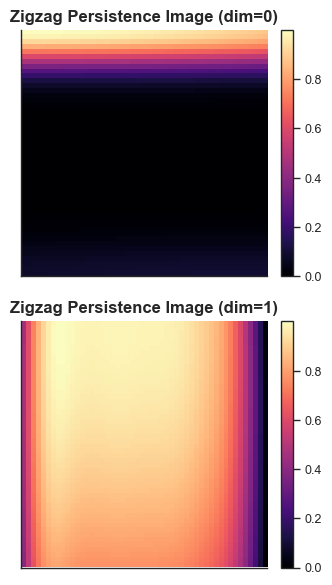

In [6]:
import numpy as np

def zigzag_persistence_images(dgms_np, resolution=(50,50), bandwidth=1.0, power=1.0, normalization=True, dim=0):
    """
    dgms_np: list of numpy arrays, 每个元素是 [[birth, death], ...]
             来自 convert_dgms_to_numpy()
    resolution: 图像大小 (nx, ny)
    bandwidth: 高斯核带宽
    power: 权重 (persistence^power)
    normalization: 是否归一化到 [0,1]
    dim: 使用哪个维度的 persistence diagram

    返回: 2D numpy array (persistence image)
    """
    if dim >= len(dgms_np):
        raise ValueError(f"dgms_np 里没有 dim={dim} 的持久图")

    dgm = dgms_np[dim]
    if dgm.size == 0:
        return np.zeros(resolution)

    # 计算 persistence
    births = dgm[:,0]
    deaths = dgm[:,1]
    pers   = deaths - births

    # 网格
    xmin, xmax = births.min(), births.max()
    ymin, ymax = pers.min(), pers.max()
    xs = np.linspace(xmin, xmax, resolution[0])
    ys = np.linspace(ymin, ymax, resolution[1])
    X, Y = np.meshgrid(xs, ys)

    Z = np.zeros_like(X)
    for (b, d, p) in zip(births, deaths, pers):
        if np.isinf(d):   # 过滤掉 inf
            continue
        w = p**power
        Z += w * np.exp(-((X-b)**2 + (Y-p)**2) / (2*bandwidth**2))

    if normalization:
        Z = (Z - Z.min()) / (Z.max() - Z.min() + 1e-8)

    return Z

# ===== 使用示例 =====
# 你前面得到的 dgms 是 convert_dgms_to_numpy() 返回的
pi0 = zigzag_persistence_images(dgms, resolution=(50,50), bandwidth=1.0, power=1.0, normalization=True, dim=0)
pi1 = zigzag_persistence_images(dgms, resolution=(50,50), bandwidth=1.0, power=1.0, normalization=True, dim=1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# plt.imshow(pi0, cmap="hot", origin="lower")
# plt.colorbar()
# plt.title("Zigzag Persistence Image (dim=0)")
# plt.show()

fig, axs = plt.subplots(2, 1, figsize=(4,6))

cmaps = ["magma", "magma"]

for i, (pi, title) in enumerate(zip([pi0, pi1], 
                                    ["Zigzag Persistence Image (dim=0)", 
                                     "Zigzag Persistence Image (dim=1)"])):
    im = axs[i].imshow(pi, cmap=cmaps[i], origin="lower", aspect='auto')
    axs[i].set_title(title, fontsize=12, weight="bold")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # axs[i].set_xlabel("Birth", fontsize=11)
    # axs[i].set_ylabel("Persistence", fontsize=11)
    # axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].set_aspect('equal')
    sns.despine(ax=axs[i])
    cbar = plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig("ZPI.pdf", dpi=600, bbox_inches='tight')
plt.show()


class ZPIEncoder(nn.Module):
    def __init__(self, out_dim=32):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(8,out_dim)
        )
    def forward(self, pi_batch):
        return self.cnn(pi_batch)

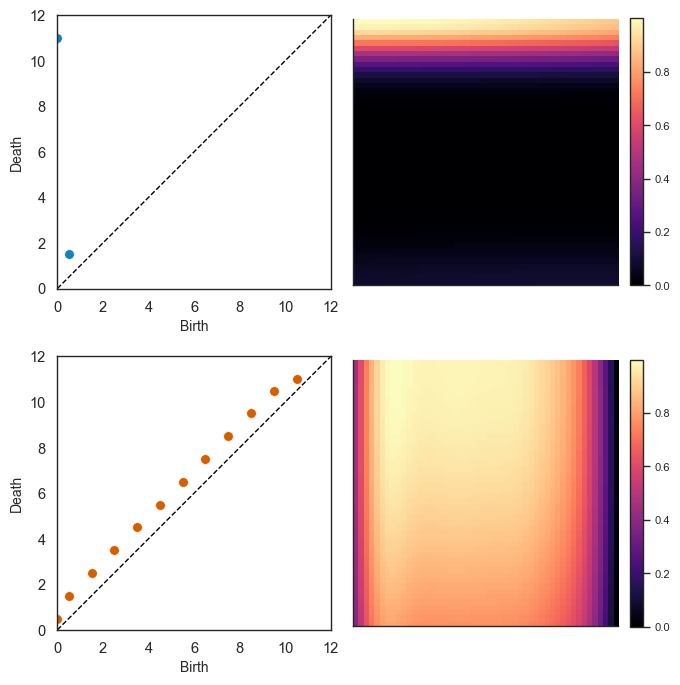

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# ===== 假设你已经得到了这两个 =====
# dgms : 由 month_graphs_to_zigzag() 生成的 numpy 列表
# pi0, pi1 : 由 zigzag_persistence_images() 生成的图像
# ===================================

# 如果 dgms 是 list[dionysus diagram]，先转成 numpy 数组（如果你没转过）
def ensure_numpy_dgms(dgms):
    if isinstance(dgms[0], np.ndarray):
        return dgms
    else:
        from dionysus import DiagramPoint
        return [np.array([[p.birth, p.death] for p in dgm]) for dgm in dgms]

dgms_np = ensure_numpy_dgms(dgms)

# ==================== 开始绘图 ====================
fig, axes = plt.subplots(2, 2, figsize=(7,7))
plt.subplots_adjust(wspace=0.2, hspace=0.25)

cmaps = ["magma", "magma"]
dim_styles = {
    0: {'color': '#0072B2', 'marker': 'o'},
    1: {'color': '#D55E00', 'marker': 's'}
}

for i, dim in enumerate([0, 1]):
    dgm = dgms_np[dim]
    births = dgm[:,0]
    deaths = dgm[:,1]
    finite_mask = np.isfinite(deaths)
    births, deaths = births[finite_mask], deaths[finite_mask]

    # -------- 左列：ZPD --------
    ax_dgm = axes[i, 0]
    ax_dgm.scatter(births, deaths, s=50, color=dim_styles[dim]['color'], 
                   edgecolor='white', linewidth=0.6, alpha=0.9)
    ax_dgm.plot([0, 12], [0, 12], 'k--', linewidth=1)
    ax_dgm.set_xlim(0, 12)
    ax_dgm.set_ylim(0, 12)
    ax_dgm.set_xlabel("Birth", fontsize=10)
    ax_dgm.set_ylabel("Death", fontsize=10)
    ax_dgm.set_aspect('equal')
    # ax_dgm.set_title(f"ZPD (dim={dim})", fontsize=12, weight='bold')
    # sns.despine(ax=ax_dgm)

    # -------- 右列：ZPI --------
    ax_pi = axes[i, 1]
    pi = [pi0, pi1][i]
    im = ax_pi.imshow(pi, cmap=cmaps[i], origin="lower", aspect='equal')
    ax_pi.set_xticks([])
    ax_pi.set_yticks([])
    # ax_pi.set_title(f"ZPI (dim={dim})", fontsize=12, weight='bold')
    sns.despine(ax=ax_pi)
    cbar = plt.colorbar(im, ax=ax_pi, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig("ZPD_ZPI_combined.pdf", dpi=600, bbox_inches='tight')
plt.show()


In [7]:
# ------------------- Merge Overlapping Seq2Seq Predictions -------------------
def merge_overlapping_predictions(y_pred_all, input_len=168, stride=1):
    """
    将 [num_windows, input_len] 的预测结果重叠平均融合为完整时间序列。
    参数:
        y_pred_all : np.ndarray, shape [num_windows, input_len]
        input_len  : 每个窗口的长度
        stride     : 滑动步长
    返回:
        merged_pred : np.ndarray, shape [total_hours]
    """
    num_windows = y_pred_all.shape[0]
    total_hours = num_windows * stride + input_len - stride

    merged_pred = np.zeros(total_hours)
    count = np.zeros(total_hours)

    for i in range(num_windows):
        s = i * stride
        e = s + input_len
        merged_pred[s:e] += y_pred_all[i]
        count[s:e] += 1

    merged_pred /= np.maximum(count, 1)
    return merged_pred

def merge_predictions_with_starts(y_pred_all, starts, input_len):
    """
    根据真实窗口起点索引 starts 合并预测序列，防止跨块错位。
    参数:
        y_pred_all : np.ndarray, shape [num_windows, input_len]
        starts     : list[int], 每个窗口在原时间序列中的起点索引
        input_len  : 窗口长度
    返回:
        merged_pred : np.ndarray, shape [total_hours]
    """
    total_hours = int(starts[-1] + input_len)
    merged_pred = np.zeros(total_hours)
    count = np.zeros(total_hours)

    for i, s in enumerate(starts):
        e = s + input_len
        merged_pred[s:e] += y_pred_all[i]
        count[s:e] += 1

    merged_pred /= np.maximum(count, 1)
    return merged_pred

# 4) Build continuous blocks (from reference BA dates per split)
blocks_train = find_continuous_blocks(dates_train_arr, min_len=INPUT_LEN)
blocks_val   = find_continuous_blocks(dates_val_arr,   min_len=INPUT_LEN)
blocks_test  = find_continuous_blocks(dates_test_arr,  min_len=INPUT_LEN)

print("最后一个测试日期:", dates_test_arr[-1])
print("缺口检查:")
dt = pd.to_datetime(pd.Series(dates_test_arr))
print(dt.diff().value_counts().head())

gap_idx = np.where(dt.diff() > pd.Timedelta(hours=1))[0]
for i in gap_idx:
    print("Gap detected around:")
    print(dt.iloc[max(i-3,0):i+3])  # 防止负索引
    print("--------")

print(f"len(common_dates_final) = {len(common_dates_final)}")
print("最后一个共同日期:", common_dates_final[-1])

# ------------------- Train/Eval per BA -------------------
def train_eval_tgcn_one_ba(ba_index, ba_name):
    train_ds = SeqGraphDataset(x_tensor,      y_tensor,      months_train_arr, years_train_arr, blocks_train,
                               ba_index, INPUT_LEN, STRIDE)
    val_ds   = SeqGraphDataset(x_val_tensor,  y_val_tensor,  months_val_arr, years_val_arr,   blocks_val,
                               ba_index, INPUT_LEN, STRIDE)
    test_ds  = SeqGraphDataset(x_test_tensor, y_test_tensor, months_test_arr, years_test_arr,  blocks_test,
                               ba_index, INPUT_LEN, STRIDE)

    print(len(test_ds))
    print("Last start index:", test_ds.starts[-1])
    print("Last date:", dates_test_arr[test_ds.starts[-1] + 168 - 1])

    print("日期总数:", len(dates_test_arr))
    print("前5个:", dates_test_arr[:5])
    print("最后5个:", dates_test_arr[-5:])


    tr = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
    va = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    te = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    model = TGCN_BA_RNN(
        in_ch=x_tensor.shape[-1], gcn_hidden=GCN_H, rnn_hidden=RNN_H,
        ba_index=ba_index, graph_for_month_fn=graph_for_month,
        rnn_type=RNN_TYPE, num_layers=NUM_LAYERS, bidirectional=BIDIR, pi_array=np.stack([pi0, pi1], axis=0), pi_dim=32
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
    loss_fn = nn.MSELoss()

    best = 1e9; best_state = None; bad = 0
    for ep in range(1, EPOCHS+1):
        model.train(); tr_loss = 0.0
        for x_seq, y_seq, m_seq, years in tr:
            x_seq = x_seq.to(device); y_seq = y_seq.to(device).float(); m_seq = m_seq.to(device)
            # 根据年份取对应静态特征
            years_last = years[:, -1]   # 序列最后的年份
            months_avg = m_seq.float().mean(dim=1)  # 序列平均月份（跨月更平滑）
            batch_feats = get_interpolated_feats(years_last, months_avg, ba_index, device)
            opt.zero_grad()
            pred = model(x_seq, m_seq, batch_feats)
            loss = loss_fn(pred, y_seq)
            loss.backward(); opt.step()
            tr_loss += loss.item()
        tr_loss /= max(1, len(tr))

        model.eval(); va_loss = 0.0
        with torch.no_grad():
            for x_seq, y_seq, m_seq, years in va:
                x_seq = x_seq.to(device); y_seq = y_seq.to(device).float(); m_seq = m_seq.to(device)
                # 根据年份取对应静态特征
                years_last = years[:, -1]   # 序列最后的年份
                months_avg = m_seq.float().mean(dim=1)  # 序列平均月份（跨月更平滑）
                batch_feats = get_interpolated_feats(years_last, months_avg, ba_index, device)
                va_loss += loss_fn(model(x_seq, m_seq, batch_feats), y_seq).item()
        va_loss /= max(1, len(va))
        sch.step(va_loss)

        print(f"[{ba_name}] Epoch {ep:03d} | Train {tr_loss:.4f} | Val {va_loss:.4f}")
        if va_loss < best:
            best = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"[{ba_name}] Early stop at epoch {ep}"); break
        torch.cuda.empty_cache()

    # Test
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    model.eval(); y_pred_n, y_true_n = [], []
    y_true_all, y_pred_all = [], []
    
    with torch.no_grad():
        for x_seq, y_seq, m_seq, years in te:
            # 根据年份取对应静态特征
            years_last = years[:, -1]   # 序列最后的年份
            months_avg = m_seq.float().mean(dim=1)  # 序列平均月份（跨月更平滑）
            batch_feats = get_interpolated_feats(years_last, months_avg, ba_index, device)
            pred = model(x_seq.to(device), m_seq.to(device), batch_feats)
            y_pred_all.append(pred.cpu().numpy())
            y_true_all.append(y_seq.cpu().numpy())
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)

    y_true_merged = merge_predictions_with_starts(y_true_all, test_ds.starts, input_len=INPUT_LEN)
    y_pred_merged = merge_predictions_with_starts(y_pred_all, test_ds.starts, input_len=INPUT_LEN)


    mn, mx = min_y_train_array[ba_index], max_y_train_array[ba_index]
    yt = y_true_merged * (mx - mn) + mn
    yp = y_pred_merged * (mx - mn) + mn

    aligned_dates = dates_test_arr[:len(y_pred_merged)]

    print(f"[{ba_name}] 最后一个预测日期: {aligned_dates[-1]}")
    print(f"[{ba_name}] 对应的真实值: {yt[-1]:.2f}, 预测值: {yp[-1]:.2f}")
    print(f"[{ba_name}] 预测长度: {len(yt)}, 日期长度: {len(aligned_dates)}")
    # === 对齐检查 ===
    print(f"[DEBUG] {ba_name}: len(y_pred_merged)={len(y_pred_merged)}, len(dates_test_arr)={len(dates_test_arr)}")
    print(f"[DEBUG] First aligned date = {aligned_dates[0]}")
    print(f"[DEBUG] Last aligned date  = {aligned_dates[-1]}")
    print(f"[DEBUG] y_true[0]={yt[0]:.2f}, y_pred[0]={yp[0]:.2f}")

    eps = 1e-8
    rms_abs = float(np.sqrt(np.mean((yp - yt) ** 2)))
    rms_norm = float(rms_abs / np.mean(np.abs(yt)))
    mape    = float(np.mean(np.abs((yt - yp) / (np.abs(yt) + eps))))
    r2      = float(r2_score(yt, yp))
    print(f"[{ba_name}] Test: RMS_ABS={rms_abs:.4f} RMS_NORM={rms_norm:.4f} MAPE={mape:.4f} R2={r2:.4f}")

    # === 保存预测结果到文件 ===
    save_pred_dir = f"results_tgcn2/predictions"
    os.makedirs(save_pred_dir, exist_ok=True)

    save_pred_path = os.path.join(save_pred_dir, f"{ba_name}_predictions.csv")
    pd.DataFrame({
        "Date": aligned_dates,
        "True": yt,
        "Pred": yp
    }).to_csv(save_pred_path, index=False)

    print(f"[{ba_name}] Saved predictions to {save_pred_path}")

    return {"BA": ba_name, "RMS_ABS": rms_abs, "RMS_NORM": rms_norm, "MAPE": mape, "R2": r2}

# ------------------- Run all BAs -------------------
all_results = []
for j, ba in enumerate(ba_names):
    print(f"\n===== T-GCN ({RNN_TYPE.upper()}) with MLP imputation for BA: {ba} =====")
    all_results.append(train_eval_tgcn_one_ba(j, ba))

results_dir = "results_tgcn2"
os.makedirs(results_dir, exist_ok=True)

save_path = os.path.join(results_dir, f"TGCN_{RNN_TYPE}_zigzag.csv")
pd.DataFrame(all_results).to_csv(save_path, index=False)

print(f"Saved results to {save_path}")


最后一个测试日期: 2024-12-31T21:00:00.000000000
缺口检查:
0 days 01:00:00    8683
3 days 01:00:00       1
1 days 01:00:00       1
Name: count, dtype: int64
Gap detected around:
5477   2024-08-16 05:00:00
5478   2024-08-16 06:00:00
5479   2024-08-16 07:00:00
5480   2024-08-19 08:00:00
5481   2024-08-19 09:00:00
5482   2024-08-19 10:00:00
dtype: datetime64[ns]
--------
Gap detected around:
7277   2024-11-02 05:00:00
7278   2024-11-02 06:00:00
7279   2024-11-02 07:00:00
7280   2024-11-03 08:00:00
7281   2024-11-03 09:00:00
7282   2024-11-03 10:00:00
dtype: datetime64[ns]
--------
len(common_dates_final) = 63807
最后一个共同日期: 2024-12-31 21:00:00

===== T-GCN (LSTM) with MLP imputation for BA: AVA =====
8185
Last start index: 8518
Last date: 2024-12-31T21:00:00.000000000
日期总数: 8686
前5个: ['2024-01-01T00:00:00.000000000' '2024-01-01T01:00:00.000000000'
 '2024-01-01T02:00:00.000000000' '2024-01-01T03:00:00.000000000'
 '2024-01-01T04:00:00.000000000']
最后5个: ['2024-12-31T17:00:00.000000000' '2024-12-31T18:00:00

In [9]:
print(INPUT_LEN, STRIDE)
print(len(blocks_test))
print(blocks_test[-3:])

168 1
3
[(np.int64(0), np.int64(5479)), (np.int64(5480), np.int64(7279)), (np.int64(7280), np.int64(8685))]
